### Install package and make imports:

In [1]:
!pip install ..

Processing /Users/Guille/code/GuillermoIzquierdo/GANs
  Preparing metadata (setup.py) ... done
  Created wheel for GANs-experimneting-tf: filename=GANs_experimneting_tf-0.0.1-py3-none-any.whl size=7799 sha256=932d78b7a3ab602fd559df3a29260009b824f39efdb9c2531f8c37e1d04a2d1c
  Stored in directory: /private/var/folders/0w/yx9msd751_v0j2zv7hy8zp1w0000gp/T/pip-ephem-wheel-cache-gnvwpomr/wheels/bf/a9/d6/1bea89027c0d47b5ec122bce59f312b9f3304766c2b18e0c43
Successfully built GANs-experimneting-tf
  Attempting uninstall: GANs-experimneting-tf
    Found existing installation: GANs-experimneting-tf 0.0.1
    Uninstalling GANs-experimneting-tf-0.0.1:
      Successfully uninstalled GANs-experimneting-tf-0.0.1


In [2]:
# External
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

# From our own package
from gans.models.union import construct_models
from gans.models.discriminator import build_discriminator
from gans.models.generator import build_generator, build_generator_test
from gans.utils.params import *
from gans.tfm.tfms import make_discriminator_model, make_generator_model

2022-12-16 10:46:04.776431: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Check data

In [3]:
apple_arr = np.load('../data/apple.npy')
print(type(apple_arr))
print(apple_arr.shape)

<class 'numpy.ndarray'>
(144722, 784)


In [4]:
apple_arr = apple_arr.reshape(apple_arr.shape[0], 28, 28)

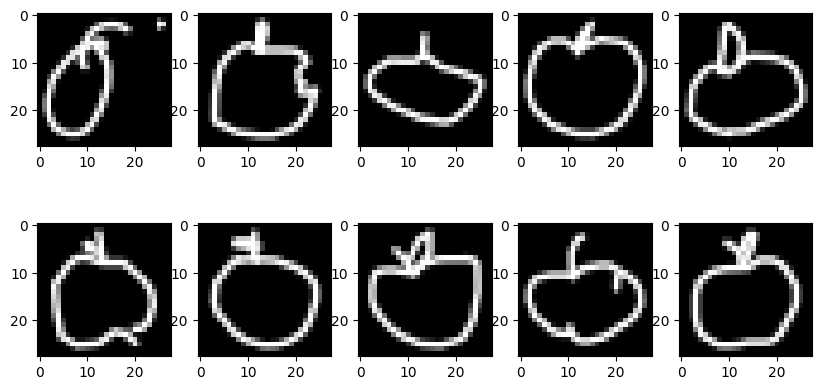

In [5]:
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
ax = ax.reshape(10)
for i in range(10):
    ax[i].imshow(apple_arr[i], cmap='gray')

### Construct model and ensure dimensions are right

In [6]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Input, GlobalAveragePooling2D, Dense, Conv2DTranspose, Reshape
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LeakyReLU, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [7]:
# we will downscale the images
SPATIAL_DIM = 32
# size of noise vector
LATENT_DIM_GAN = 100
# filter size in conv layer
FILTER_SIZE = 5
# number of filters in conv layer
NET_CAPACITY = 4
# batch size
BATCH_SIZE_GAN = 256
# interval for displaying generated images
PROGRESS_INTERVAL = 1000

In [8]:
def build_generator_test( filter_size, latent_dim):

    def add_generator_block(x, filters, filter_size, strides=2):
        x = Conv2DTranspose(filters, filter_size, strides=strides, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        return x

    inp = Input(shape=(latent_dim,))

    x = Dense(7 * 7 * 256, use_bias=False, input_shape=inp.shape)(inp)
    x = BatchNormalization()(x)
    x = Reshape(target_shape=(7, 7, 256))(x)

    # design the generator to upsample the image 4x
    x = add_generator_block(x, 128, filter_size, strides=1)
    x = add_generator_block(x, 64, filter_size, strides=2)
    x = add_generator_block(x, 1, filter_size, strides=2)
    # x = add_generator_block(x, start_filters, filter_size)

    # turn the output into a 2D tensor, an image with 3 channels
    # x = Conv2D(1, kernel_size=5, padding='same', activation='tanh')(x)

    return Model(inputs=inp, outputs=x)

In [50]:
def build_discriminator_test(spatial_dim, filter_size):

    # function for building a CNN block for downsampling the image
    def add_discriminator_block(x, filters, filter_size, dropout=0.3):
      # x = Conv2D(filters, filter_size, padding='same')(x)
      # x = BatchNormalization()(x)
      x = Conv2D(filters, filter_size, padding='same', strides=2)(x)
      # x = BatchNormalization()(x)
      x = LeakyReLU()(x)
      x = Dropout(dropout)(x)

      return x

    # input is an image with shape spatial_dim x spatial_dim and 1 channel
    inp = Input(shape=(28, 28, 1))

    # design the discrimitor to downsample the image 4x
    x = add_discriminator_block(inp, 64, filter_size)
    x = add_discriminator_block(x, 128, filter_size, dropout=0.1)
    # x = add_discriminator_block(x, start_filters * 4, filter_size)
    # x = add_discriminator_block(x, start_filters * 8, filter_size)

    # average and return a binary output
    x = Flatten()(x)
    x = Dense(1)(x)

    return Model(inputs=inp, outputs=x)

In [51]:
disc = build_discriminator_test(SPATIAL_DIM, FILTER_SIZE)

In [52]:
def construct_models(verbose=False):
    ### discriminator
    discriminator = build_discriminator_test(SPATIAL_DIM, FILTER_SIZE)
    # compile discriminator
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['mae'])

    ### generator
    # do not compile generator
    generator = build_generator_test(FILTER_SIZE, LATENT_DIM_GAN)

    ### DCGAN
    gan = Sequential()
    gan.add(generator)
    gan.add(discriminator)
    discriminator.trainable = False
    gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002), metrics=['mae'])

    if verbose:
        generator.summary()
        discriminator.summary()
        gan.summary()

    return generator, discriminator, gan

In [53]:
generator, discriminator, gan = construct_models(verbose=False)

(1, 28, 28, 1)


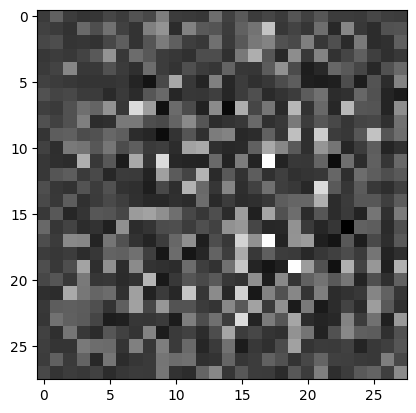

In [54]:
# Untrained generator's 'prediction' given random noise:

noise = np.random.random([1, 100])
generated_image = generator(noise, training=False)
print(generated_image.shape)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [55]:
# Untrained discriminator's decision on generated image:

decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00243258]], shape=(1, 1), dtype=float32)


In [56]:
from tensorflow.keras.losses import BinaryCrossentropy

In [57]:
cross_entropy = BinaryCrossentropy(from_logits=True)
cross_entropy.get_config()

{'reduction': 'auto',
 'name': 'binary_crossentropy',
 'from_logits': True,
 'label_smoothing': 0.0,
 'axis': -1}

In [58]:
apple_norm = (apple_arr - 127.5) / 127.5
apple_norm.shape

(144722, 28, 28)

In [59]:
np.expand_dims(apple_norm, axis=3).shape

(144722, 28, 28, 1)

In [60]:
np.expand_dims(apple_arr, axis = 3).shape

(144722, 28, 28, 1)

In [61]:
imgs_real_arr = apple_arr[np.random.randint(0, apple_arr.shape[0], BATCH_SIZE_GAN)]
print(imgs_real_arr.shape)

imgs_real_norm = apple_norm[np.random.randint(0, apple_norm.shape[0], BATCH_SIZE_GAN)]
print(imgs_real_norm.shape)

(256, 28, 28)
(256, 28, 28)


In [62]:
assert imgs_real_norm[0].shape == imgs_real_arr[0].shape

In [63]:
loss_arr = discriminator.train_on_batch(np.expand_dims(imgs_real_arr, axis=3), np.ones([BATCH_SIZE_GAN]))
loss_norm = discriminator.train_on_batch(np.expand_dims(imgs_real_norm, axis=3), np.ones([BATCH_SIZE_GAN]))

In [64]:
loss_arr

[13.843456268310547, 14.962428092956543]

In [65]:
loss_norm

[15.331015586853027, 1.183293342590332]

In [66]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import clear_output

# number of discriminator updates per alternating training iteration
DISC_UPDATES = 1
# number of generator updates per alternating training iteration
GEN_UPDATES = 1

TOTAL_SAMPLES = apple_arr.shape[0]

LOCAL_DATA_PATH = '/Users/Guille/code/GuillermoIzquierdo/GANs'

# function for training a GAN
def run_training(generator, discriminator, gan, start_it=0, num_epochs=1000, arr=apple_norm):

  # list for storing loss
  avg_loss_discriminator = []
  avg_loss_generator = []
  total_it = start_it

  # main training loop
  for epoch in range(num_epochs):

      # alternating training loop
      loss_discriminator = []
      loss_generator = []
      for it in range(200):

          #### Discriminator training loop ####
          for i in range(DISC_UPDATES):
              # select a random set of real images
              imgs_real = arr[np.random.randint(0, arr.shape[0], BATCH_SIZE_GAN)]
              imgs_real = np.expand_dims(imgs_real, axis=3)
              # generate a set of random noise vectors
              noise = np.random.randn(BATCH_SIZE_GAN, LATENT_DIM_GAN)
              # generate a set of fake images using the generator
              imgs_fake = generator.predict(noise)
              # train the discriminator on real images with label 1
              d_loss_real = discriminator.train_on_batch(imgs_real, np.ones([BATCH_SIZE_GAN]))[1]
              # train the discriminator on fake images with label 0
              d_loss_fake = discriminator.train_on_batch(imgs_fake, np.zeros([BATCH_SIZE_GAN]))[1]

          # display some fake images for visual control of convergence
          if total_it % PROGRESS_INTERVAL == 0:
              plt.figure(figsize=(5,2))
              num_vis = min(BATCH_SIZE_GAN, 5)
              imgs_real = arr[np.random.randint(0, arr.shape[0], BATCH_SIZE_GAN)]
              imgs_real = np.expand_dims(imgs_real, axis=3)
              noise = np.random.randn(num_vis, LATENT_DIM_GAN)
              imgs_fake = generator.predict(noise)
              for obj_plot in [imgs_fake, imgs_real]:
                  plt.figure(figsize=(num_vis * 3, 3))  
                  for b in range(num_vis):
                      disc_score = float(discriminator.predict(np.expand_dims(obj_plot[b], axis=0))[0])
                      plt.subplot(1, num_vis, b + 1)
                      plt.title(str(round(disc_score, 3)))
                      plt.imshow(obj_plot[b].reshape(28, 28) * 0.5 + 0.5, cmap='gray')
                  if obj_plot is imgs_fake:
                      plt.savefig(os.path.join(LOCAL_DATA_PATH + '/visualization', str(total_it).zfill(10) + '.jpg'), format='jpg', bbox_inches='tight')
                  plt.show()

          #### Generator training loop ####
          loss = 0
          y = np.ones([BATCH_SIZE_GAN, 1])
          for j in range(GEN_UPDATES):
              # generate a set of random noise vectors
              noise = np.random.randn(BATCH_SIZE_GAN, LATENT_DIM_GAN)
              # train the generator on fake images with label 1
              loss += gan.train_on_batch(noise, y)[1]

          # store loss
          loss_discriminator.append((d_loss_real + d_loss_fake) / 2.)
          loss_generator.append(loss / GEN_UPDATES)
          total_it += 1

      # visualize loss
      clear_output(True)
      print('Epoch', epoch)
      avg_loss_discriminator.append(np.mean(loss_discriminator))
      avg_loss_generator.append(np.mean(loss_generator))
      plt.plot(range(len(avg_loss_discriminator)), avg_loss_discriminator)
      plt.plot(range(len(avg_loss_generator)), avg_loss_generator)
      plt.legend(['discriminator loss', 'generator loss'])
      plt.show()

  return generator, discriminator, gan


1/1 [==============================] - 0s 27ms/step


<Figure size 500x200 with 0 Axes>

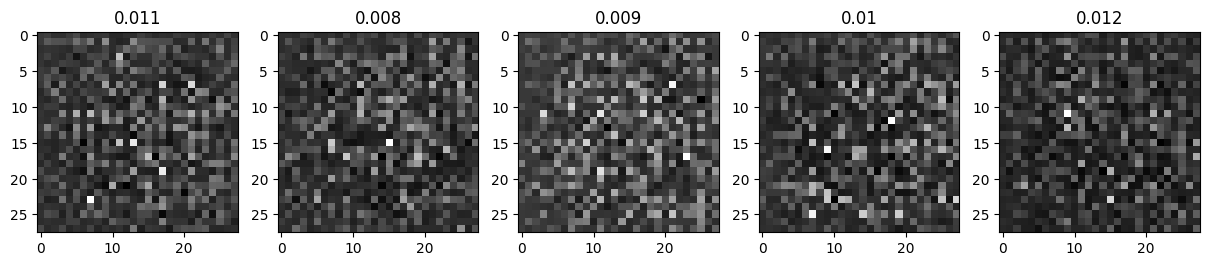

1/1 [==============================] - 0s 28ms/step


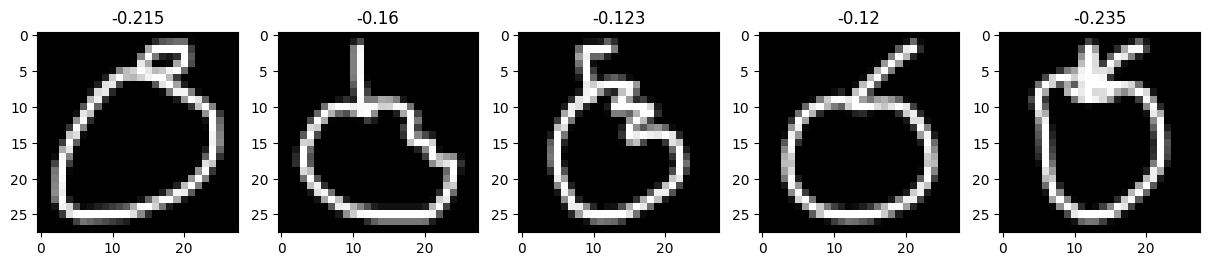

8/8 [==============================] - 1s 135ms/step


KeyboardInterrupt: 

In [67]:
gen_tr, disc_tr, gan_tr = run_training(generator, discriminator, gan, start_it=0, num_epochs=50, arr=apple_norm)